# CNTNAP2

[Pitt-Hopkins like syndrome 1 (PTHSL1)](https://omim.org/entry/610042) is  an autosomal recessive neurodevelopmental disorder. The syndrome is caused by pathogenic variants in the [CNTNAP2](https://omim.org/entry/604569) gene.

[D'Onofrio et al. (2023)](https://pubmed.ncbi.nlm.nih.gov/37183190/) compared monoallelic and biallelic cases:

> Overall, GDD (p < 0.0001), epilepsy (p < 0.0001), hyporeflexia (p = 0.012), ASD (p = 0.009), language impairment (p = 0.020) and severe cognitive impairment (p = 0.031) were significantly associated with the presence of biallelic versus monoallelic variants.

> Therefore, we tested the phenotypic spectrum of cases with monoallelic and biallelic variants in CNTNAP2. We curated all of the cases used in the 
[D'Onofrio et al. (2023)](https://pubmed.ncbi.nlm.nih.gov/37183190/) publication.

## Imports 

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2023-10-09')
print(f'Loaded HPO v{hpo.version}')
print(f"Using genophenocorr version {gpsea.__version__}")

Loaded HPO v2023-10-09
Using genophenocorr version 0.9.1.dev0


## CNTNAP2
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for CNTNAP2.

In [2]:
gene_symbol = 'CNTNAP2'
mane_tx_id = 'NM_014141.6'
mane_protein_id = 'NP_054860.1' # contactin-associated protein-like 2 precursor

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store('0.1.22') as ps:
        phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)

cohort, qc_results = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
qc_results.summarize()

Individuals Processed: 100%|██████████| 63/63 [01:46<00:00,  1.70s/individuals]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer
cv = CohortViewer(hpo=hpo)
cv.process(cohort=cohort, transcript_id=mane_tx_id)

n,HPO Term
51,Intellectual disability
51,Delayed speech and language development
48,Global developmental delay
30,EEG abnormality
16,Hypotonia
16,Seizure
14,Aggressive behavior
13,Autistic behavior
12,Delayed gross motor development
12,Bilateral tonic-clonic seizure


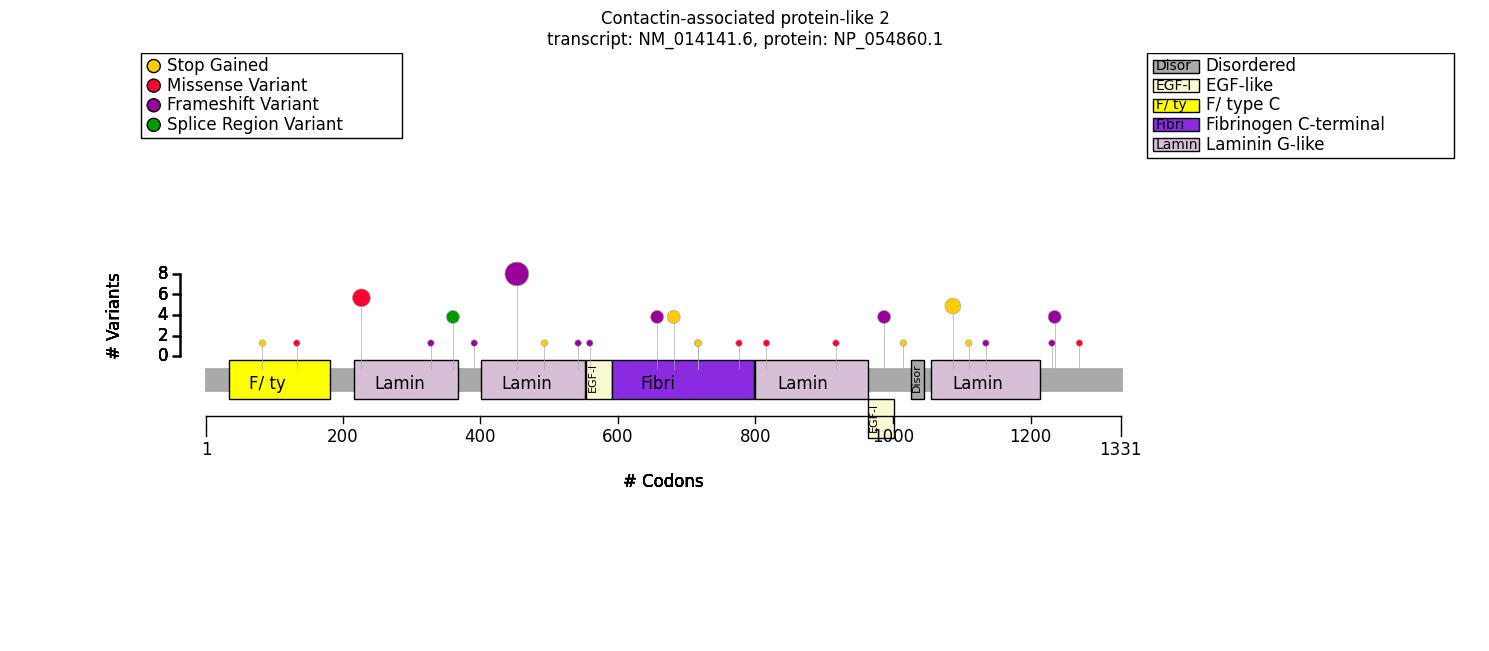

In [5]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)


CNTNAP2_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
CNTNAP2_fig.tight_layout()

In [6]:
from gpsea.view import ProteinVariantViewer
viewer = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
viewer.process(cohort)


Count,Name,Type,Coordinates,Variants
2,F5/8 type C,Domain,36 - 181,p.Trp84Ter; p.Trp134Gly
7,Laminin G-like 1,Domain,217 - 368,p.Ser329ValfsTer28; p.Val361=; p.Gly228Arg
10,Laminin G-like 2,Domain,402 - 552,p.Asn454ArgfsTer24; p.Ser543IlefsTer13; p.Glu494Ter
1,EGF-like 1,Domain,555 - 591,p.Asn561IlefsTer45
7,Fibrinogen C-terminal,Domain,593 - 798,p.Tyr717Ter; p.Cys682Ter; p.Arg777Gly; p.Val660PhefsTer9; p.Trp718Ter
2,Laminin G-like 3,Domain,800 - 963,p.Gly817Arg; p.Leu918Phe
2,EGF-like 2,Domain,964 - 1002,p.Cys989AlafsTer45
0,Disordered,Region,1027 - 1045,
5,Laminin G-like 4,Domain,1056 - 1214,p.Arg1088Ter; p.Tyr1136SerfsTer27; p.Gln1111Ter


## Genotype-Phenotype Correlation (GPC) Analysis

In [7]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
pheno_predicates = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [8]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate import variant_effect
from gpsea.view import MtcStatsViewer
from gpsea.analysis.clf import biallelic_classifier

ablation = variant_effect(VariantEffect.TRANSCRIPT_ABLATION, tx_id=mane_tx_id)
ablation_predicate = biallelic_classifier(a_predicate=ablation,
                                           b_predicate=~ablation,
                                           a_label="Ablation",
                                           b_label="other",
                                           partitions=((0,),(2,1)))
ablation_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=ablation_predicate,
    pheno_clfs=pheno_predicates,
)

viewer = MtcStatsViewer()
viewer.process(ablation_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,80
HMF08,Skipping general term,45
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,90


In [9]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=ablation_result)

Allele group                                       Ablation/Ablation          \
                                                               Count Percent   
Bilateral tonic-clonic seizure with focal onset...               4/5     80%   
Hyperventilation [HP:0002883]                                    3/7     43%   
Global developmental delay [HP:0001263]                          8/9     89%   
EEG abnormality [HP:0002353]                                     5/5    100%   
Aggressive behavior [HP:0000718]                                 1/4     25%   
Tonic seizure [HP:0032792]                                       2/5     40%   
Neurodevelopmental delay [HP:0012758]                            9/9    100%   
Neurodevelopmental abnormality [HP:0012759]                      9/9    100%   
Intellectual disability [HP:0001249]                             9/9    100%   
Abnormal communication [HP:0034434]                              9/9    100%   
Atypical behavior [HP:0000708]                                   4/4    100%   
Abnormality of central nervous system electroph...               5/5    100%   
Seizure [HP:0001250]                                             7/7    100%   
Delayed speech and language development [HP:000...               9/9    100%   
Language impairment [HP:0002463]                                 9/9    100%   
Abnormality of speech or vocalization [HP:0002167]               9/9    100%   

Allele group                                       other/other OR Ablation/other  \
                                                                           Count   
Bilateral tonic-clonic seizure with focal onset...                          3/26   
Hyperventilation [HP:0002883]                                               3/27   
Global developmental delay [HP:0001263]                                    29/30   
EEG abnormality [HP:0002353]                                               23/29   
Aggressive behavior [HP:0000718]                                           11/24   
Tonic seizure [HP:0032792]                                                  8/27   
Neurodevelopmental delay [HP:0012758]                                      36/36   
Neurodevelopmental abnormality [HP:0012759]                                36/36   
Intellectual disability [HP:0001249]                                       32/32   
Abnormal communication [HP:0034434]                                        32/32   
Atypical behavior [HP:0000708]                                             22/22   
Abnormality of central nervous system electroph...                         23/23   
Seizure [HP:0001250]                                                       35/35   
Delayed speech and language development [HP:000...                         31/32   
Language impairment [HP:0002463]                                           31/31   
Abnormality of speech or vocalization [HP:0002167]                         31/31   

Allele group                                                                   \
                                                   Percent Corrected p values   
Bilateral tonic-clonic seizure with focal onset...     12%           0.081078   
Hyperventilation [HP:0002883]                          11%           0.685456   
Global developmental delay [HP:0001263]                97%           1.000000   
EEG abnormality [HP:0002353]                           79%           1.000000   
Aggressive behavior [HP:0000718]                       46%           1.000000   
Tonic seizure [HP:0032792]                             30%           1.000000   
Neurodevelopmental delay [HP:0012758]                 100%           1.000000   
Neurodevelopmental abnormality [HP:0012759]           100%           1.000000   
Intellectual disability [HP:0001249]                  100%           1.000000   
Abnormal communication [HP:0034434]                   100%           1.000000   
Atypical behavior [HP:0000708]                        100%           1.000

In [10]:
from gpsea.analysis.clf import sex_classifier

mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=mf_result)

Sex                                                FEMALE           MALE  \
                                                    Count Percent  Count   
Aggressive behavior [HP:0000718]                     9/14     64%   4/18   
Hypotonia [HP:0001252]                                7/8     88%   9/19   
Seizure [HP:0001250]                                25/27     93%  28/28   
Focal-onset seizure [HP:0007359]                    11/13     85%  13/13   
Delayed speech and language development [HP:000...  25/28     89%  26/27   
Global developmental delay [HP:0001263]             24/26     92%  24/28   
EEG abnormality [HP:0002353]                        13/15     87%  16/21   
Neurodevelopmental delay [HP:0012758]               27/27    100%  30/30   
Neurodevelopmental abnormality [HP:0012759]         27/27    100%  30/30   
Intellectual disability [HP:0001249]                26/28     93%  23/24   
Abnormal communication [HP:0034434]                 26/26    100%  26/26   
Atypical behavior [HP:0000708]                      16/16    100%  13/13   
Abnormality of central nervous system electroph...  13/13    100%  16/16   
Language impairment [HP:0002463]                    25/25    100%  26/26   
Abnormality of speech or vocalization [HP:0002167]  25/25    100%  26/26   

Sex                                                                            \
                                                   Percent Corrected p values   
Aggressive behavior [HP:0000718]                       22%           0.438925   
Hypotonia [HP:0001252]                                 47%           0.674285   
Seizure [HP:0001250]                                  100%           1.000000   
Focal-onset seizure [HP:0007359]                      100%           1.000000   
Delayed speech and language development [HP:000...     96%           1.000000   
Global developmental delay [HP:0001263]                86%           1.000000   
EEG abnormality [HP:0002353]                           76%           1.000000   
Neurodevelopmental delay [HP:0012758]                 100%           1.000000   
Neurodevelopmental abnormality [HP:0012759]           100%           1.000000   
Intellectual disability [HP:0001249]                   96%           1.000000   
Abnormal communication [HP:0034434]                   100%           1.000000   
Atypical behavior [HP:0000708]                        100%           1.000000   
Abnormality of central nervous system electroph...    100%           1.000000   
Language impairment [HP:0002463]                      100%           1.000000   
Abnormality of speech or vocalization [HP:0002167]    100%           1.000000   

Sex                                                           
                                                    p values  
Aggressive behavior [HP:0000718]                    0.029262  
Hypotonia [HP:0001252]                              0.089905  
Seizure [HP:0001250]                                0.236364  
Focal-onset seizure [HP:0007359]                    0.480000  
Delayed speech and language development [HP:000...  0.610978  
Global developmental delay [HP:0001263]             0.670208  
EEG abnormality [HP:0002353]                        0.673781  
Neurodevelopmental delay [HP:0012758]               1.000000  
Neurodevelopmental abnormality [HP:0012759]         1.000000  
Intellectual disability [HP:0001249]                1.000000  
Abnormal communication [HP:0034434]                 1.000000  
Atypical behavior [HP:0000708]                      1.000000  
Abnormality of central nervous system electroph...  1.000000  
Language impairment [HP:0002463]                    1.000000  
Abnormality of speech or vocalization [HP:0002167]  1.000000

In [11]:
# count
from gpsea.analysis.clf import allele_count
from gpsea.analysis.predicate import gene
affects_CNTNAP2 = gene(symbol="CNTNAP2")
cntnap2_count_predicate = allele_count(
    counts=({1,}, {2,}),
    target=affects_CNTNAP2,
)
cntnap2_count_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=cntnap2_count_predicate,
    pheno_clfs=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=cntnap2_count_result)

Allele count                                            1              2  \
                                                    Count Percent  Count   
Hyperventilation [HP:0002883]                        4/10     40%   1/22   
EEG abnormality [HP:0002353]                          7/8     88%  16/22   
Global developmental delay [HP:0001263]             13/13    100%  21/22   
Neurodevelopmental delay [HP:0012758]               15/15    100%  27/27   
Neurodevelopmental abnormality [HP:0012759]         15/15    100%  27/27   
Intellectual disability [HP:0001249]                11/11    100%  25/25   
Abnormal communication [HP:0034434]                 12/12    100%  25/25   
Seizure [HP:0001250]                                13/13    100%  28/28   
Delayed speech and language development [HP:000...  12/12    100%  24/25   
Language impairment [HP:0002463]                    12/12    100%  24/24   
Abnormality of speech or vocalization [HP:0002167]  12/12    100%  24/24   

Allele count                                                                   \
                                                   Percent Corrected p values   
Hyperventilation [HP:0002883]                           5%           0.266129   
EEG abnormality [HP:0002353]                           73%           1.000000   
Global developmental delay [HP:0001263]                95%           1.000000   
Neurodevelopmental delay [HP:0012758]                 100%           1.000000   
Neurodevelopmental abnormality [HP:0012759]           100%           1.000000   
Intellectual disability [HP:0001249]                  100%           1.000000   
Abnormal communication [HP:0034434]                   100%           1.000000   
Seizure [HP:0001250]                                  100%           1.000000   
Delayed speech and language development [HP:000...     96%           1.000000   
Language impairment [HP:0002463]                      100%           1.000000   
Abnormality of speech or vocalization [HP:0002167]    100%           1.000000   

Allele count                                                  
                                                    p values  
Hyperventilation [HP:0002883]                       0.024194  
EEG abnormality [HP:0002353]                        0.637807  
Global developmental delay [HP:0001263]             1.000000  
Neurodevelopmental delay [HP:0012758]               1.000000  
Neurodevelopmental abnormality [HP:0012759]         1.000000  
Intellectual disability [HP:0001249]                1.000000  
Abnormal communication [HP:0034434]                 1.000000  
Seizure [HP:0001250]                                1.000000  
Delayed speech and language development [HP:000...  1.000000  
Language impairment [HP:0002463]                    1.000000  
Abnormality of speech or vocalization [HP:0002167]  1.000000

In [12]:
from gpsea.analysis.temporal.endpoint import disease_onset
phls1 = "OMIM:610042" #Pitt-Hopkins like syndrome 1	OMIM:610042	
endpoint = disease_onset(disease_id=phls1)
from gpsea.analysis.temporal.stats import LogRankTest
survival_statistic = LogRankTest()
from gpsea.analysis.temporal import SurvivalAnalysis
survival_analysis = SurvivalAnalysis(
    statistic=survival_statistic,
)
count_onset_result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_clf=cntnap2_count_predicate,
    endpoint=endpoint,
)
print(f"survival analysis p={count_onset_result.pval:.5f}")

survival analysis p=0.00001


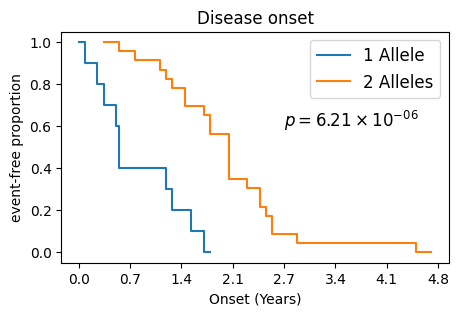

In [13]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

onset_fig, ax = plt.subplots(figsize=(5, 3))
count_onset_result.plot_kaplan_meier_curves(ax=ax)
def days_to_years(x, pos):
    return f"{x / 365.25:.1f}"


ax.xaxis.set_major_formatter(FuncFormatter(days_to_years))
ax.set_xlabel("Onset (Years)")
ax.set_ylabel("event-free proportion")
ax.set_title("Disease onset")
s = f"p={count_onset_result.pval:.2e}".replace('e', ' \\times 10^{').replace('+', '') + '}'
ax.text(x=1000, y=0.6, s=f"${s}$", fontsize=12)

legend_labels = ["1 Allele", "2 Alleles"]

# Assuming you already have plotted lines with handles
lines = ax.get_lines()  # Get the line objects
ax.legend(handles=lines, labels=legend_labels, loc="best", fontsize=12)

# Summary

In [14]:
from gpseacs.report import  GPAnalysisResultSummary, GpseaAnalysisReport

m_results = (
    GPAnalysisResultSummary.from_mono(
        result=count_onset_result,
    ),
)

f_results =  (
 GPAnalysisResultSummary.from_multi(
        result=ablation_result,
    ), GPAnalysisResultSummary.from_multi(
        result=mf_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=cntnap2_count_result,
    ), 
)



cohort_name = gene_symbol

report = GpseaAnalysisReport(
    name=cohort_name,
    cohort=cohort,
    mono_results=m_results,
    fet_results=f_results,
    gene_symbol=gene_symbol,
    mane_tx_id=mane_tx_id,
    mane_protein_id=mane_protein_id,
)

In [15]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [16]:
summarizer.process_latex(report=report, protein_fig=CNTNAP2_fig, stats_fig=onset_fig)

Figure saved to ../../supplement/img/CNTNAP2_protein_diagram-draft.pdf
Figure saved to ../../supplement/img/CNTNAP2_stats-draft.pdf
Output to ../../supplement/tex/CNTNAP2_summary_draft.tex
